<a href="https://colab.research.google.com/github/zjchen77/MachineTranslationTune/blob/main/%E2%80%9Cfine_tune_hugging_face_translation_model_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### If you dont want to use Wandb, disable Wandb otherwise optional

references for WANDB
https://analyticsindiamag.com/hands-on-guide-to-weights-and-biases-wandb-with-python-implementation/

https://docs.wandb.ai/


In [ ]:
import os
os.environ["WANDB_DISABLED"]="true"

# Install required packages

In [ ]:
! pip install datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 10.6 MB/s 
     |████████████████████████████████| 1.2 MB 48.2 MB/s 


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version

In [ ]:
import transformers
print(transformers.__version__)

4.20.1


# Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the hugging-face Transformers model for a english to romanian translation task. We will use the WMT dataset, a machine translation dataset composed from a collection of various sources, including news commentaries and parliament proceedings.

Below is the example translation text using pre-trained model

Reference : https://huggingface.co/Helsinki-NLP/opus-mt-en-ro


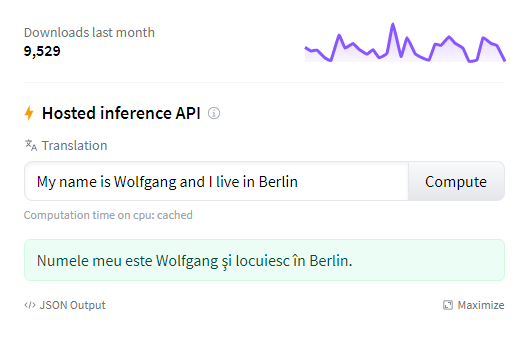

We will see how to easily load the dataset for this task using Datasets and how to fine-tune a model on it using the Trainer API

This notebook is built to run with any model checkpoint from the Model Hub as long as that model has a sequence-to-sequence version in the Transformers library. Here we picked the Helsinki-NLP/opus-mt-en-ro checkpoint.
**[You may not download the model when you working in private cloud, we can download model from Files and versions tab.]**

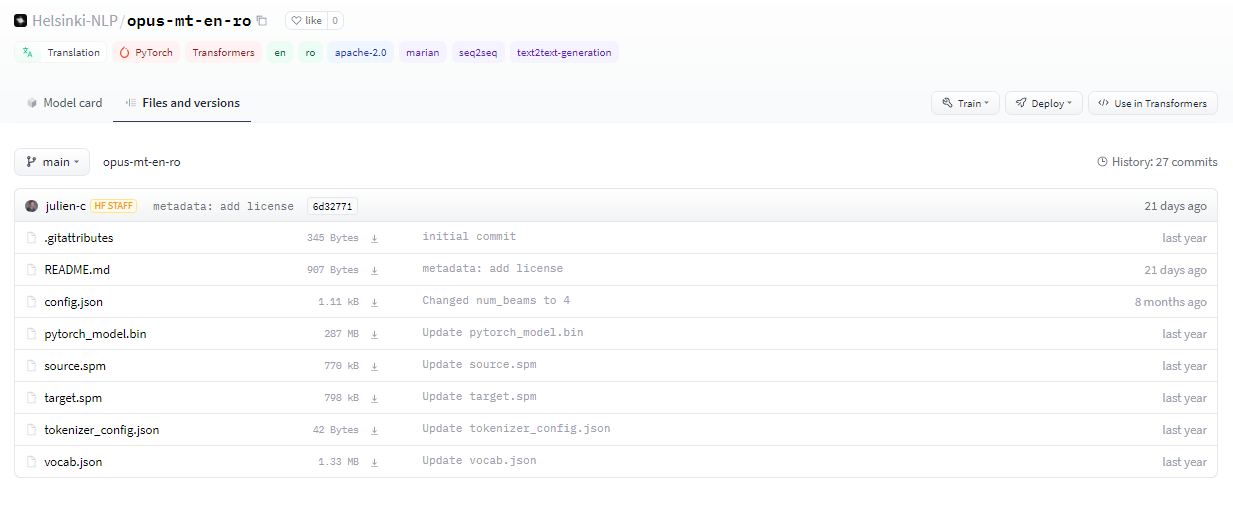



In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-zh"

### Loading the dataset

We will use the [datasets](https://github.com/huggingface/datasets/tree/master/datasets/wmt16) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric. We use the English/Romanian part of the WMT dataset here

In [ ]:
!cd /content/drive/

In [ ]:
!pwd

/content


In [ ]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 29.9 MB/s 
     |████████████████████████████████| 4.4 MB 54.2 MB/s 
     |████████████████████████████████| 212 kB 69.0 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
     |████████████████████████████████| 140 kB 73.3 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 596 kB 73.2 MB/s 
     |████████████████████████████████| 127 kB 75.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.1 MB/s 
     |████████████████████████████████| 144 kB 68.0 MB/s 
     |████████████████████████████████| 271 kB 72.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existin

In [ ]:
from __future__ import absolute_import, division, print_function

import csv
import json
import os

import datasets

_URLs = {    # 本地文件的路径
    'train': "drive/MyDrive/translation2019zh/translation2019zh_train.json",
    'dev': "drive/MyDrive/translation2019zh/translation2019zh_valid.json"  
}

In [ ]:
from datasets import load_dataset
dataset = load_dataset('json', data_files=_URLs['train'])


Using custom data configuration default-8c42a0a2780b1f5a


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8c42a0a2780b1f5a/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
validation = load_dataset('json', data_files=_URLs['dev'])

Using custom data configuration default-f982774eb1108574


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-f982774eb1108574/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['english', 'chinese'],
        num_rows: 5161434
    })
})

In [ ]:
validation

DatasetDict({
    train: Dataset({
        features: ['english', 'chinese'],
        num_rows: 39323
    })
})

In [ ]:
class Entozh(datasets.GeneratorBasedBuilder):
    """TODO: Short description of my dataset."""

    VERSION = datasets.Version("1.1.0")
    BUILDER_CONFIGS = [
        datasets.BuilderConfig(name="Plain_text", version=VERSION, description="Plain text"),
    ]    # 对数据集的概述
    
    def _info(self):
        return datasets.DatasetInfo(
            # 这是将出现在“数据集”页面上的描述。
            description=_DESCRIPTION,
            # 这定义了数据集的不同列及其类型
            features=datasets.Features(
                {
                    "id": datasets.Value("string"),
                    "question": datasets.Value("string"),
                    "passage": datasets.Value("string"),
                    "answer": datasets.Value("string"),
                }
            ),     # 这一部分定义了输出关键字的类型，和要输出的关键字
            supervised_keys=None,
            homepage=_HOMEPAGE,
            license=_LICENSE,
            citation=_CITATION,
        )

    def _split_generators(self, dl_manager):
        """Returns SplitGenerators."""
        # 这个方法用来下载/提取数据，依据configurations分割数据
        # 如果可能有几种配置(在BUILDER_CONFIGS中列出)，则用户选择的配置在self.config.name中
        
        # dl_manager is a datasets.download.DownloadManager 用来下载和抽取url
        # 它可以接受任何类型或嵌套的list/dict，并将返回相同的结构，也可以将url替换为本地文件的路径。
        # 默认情况下，将提取归档文件，并返回到提取归档文件的缓存文件夹的路径，而不是归档文件
        data_dir = dl_manager.download_and_extract(_URLs)
        print(data_dir)
        return [
            datasets.SplitGenerator(
                name=datasets.Split.TRAIN,
                # These kwargs will be passed to _generate_examples kwargs将会传参给_generate_examples
                gen_kwargs={
                    "filepath": os.path.join(data_dir["train"]),
                    "split": "train",
                },
            ),
            datasets.SplitGenerator(
                name=datasets.Split.VALIDATION,
                # These kwargs will be passed to _generate_examples
                gen_kwargs={
                    "filepath": os.path.join(data_dir["dev"]),
                    "split": "dev",
                },
            ),
        ]

    def _generate_examples(self, filepath, split):
        """ Yields examples. """
        # 这个方法将接收在前面的' _split_generators '方法中定义的' gen_kwargs '作为参数。
        # It is in charge of opening the given file and yielding (key, example) tuples from the dataset
        # The key is not important, it's more here for legacy reason (legacy from tfds)
        # 它负责打开给定的文件并从数据集生成元组(键，示例)
        # key是不重要的，更多的是为了传承

        # 这里就是根据自己的数据集来整理
        file = open("D:\\计算机\\代码\\finetune\\translation2019zh\\translation2019zh_valid.json", 'r', encoding='utf-8')
        papers = []
        '''with open(filepath, encoding="utf-8") as f:
          data = json.loads(f)'''
        for line in file.readlines():
          dic = json.loads(line)
          data.append(dic)

            '''for questions in data:    # 读列表中的其中第一个字典
                id_ = questions['id'].strip()
                question = questions['question'].strip()
                passages = questions['passages']
                for passage_n in passages:
                    answer = passage_n['answer'].strip()
                    passage = passage_n['passage'].strip()
                        
                    yield id_, {
                        "id": id_,
                        "question": question,
                        "passage": passage,
                        "answer":answer
                    }'''
            for pairs in data:    # 读列表中的其中第一个字典
                english = pairs['english'].strip()
                chinese = pairs['chinese']
                
                yield {

                    "english": english,
                    "chinese": chinese,
                }


In [ ]:
from datasets import load_dataset, load_metric

metric = load_metric("sacrebleu")

The dataset object itself is [datasetdict](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set:

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 610320
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
})

In [ ]:
raw_datasets["train"][0]

{'translation': {'en': 'Membership of Parliament: see Minutes',
  'ro': 'Componenţa Parlamentului: a se vedea procesul-verbal'}}

To get a sense of how the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
show_random_elements(dataset["train"])

,english,chinese
0,"The user selects one item, and additional details about that item are presented to the user (search and review behavior).",当用户选择一个项时，关于这个项的附加细节将被显示给用户（搜索和查看行为）。
1,Consider just the following.,思考一下以下这段便可得知。
2,"The country used to suffer much from epidemic diseases, which ere largely caused by the wretchedly bad water which the natives obtained from stagnant pools and contaminated streams.",过去，整个农村经常遭受流行病的肆虐，这大半是由于住民取用不乾净的水源，包括不流动的池水、受到污染的河水。
3,"Our goals are simply stated – no accidents, no harm to people, and no damage to the environment.",我们的目标简而言之可归纳为：无事故、无人身伤害和无环境损害。
4,"In fact, he says, just the possibility of contamination is starting to hurt.",实际上，他说，交叉污染的危害很可能已经开始了。


In [ ]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

You can call its compute method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

In [ ]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)

{'bp': 1.0,
 'counts': [4, 2, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'ref_len': 4,
 'score': 0.0,
 'sys_len': 4,
 'totals': [4, 2, 0, 0]}

# Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use,
we download the vocabulary used when pretraining this specific checkpoint.
That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

If you downloaded the model manually, you can provide model present directory instead of model_checkpoint

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:198: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[3828, 2, 58, 141, 4857, 50, 0], [208, 32, 1167, 4857, 6, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the as_target_tokenizer context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[1541, 25098, 2, 58, 8, 3795, 98, 4443, 6670, 50, 0], [208, 32, 8, 1783, 15922, 98, 4443, 6670, 6, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


We can then write the function that will preprocess our samples. We just feed them to the tokenizer with the argument truncation=True. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [ ]:
prefix = ""
max_input_length = 128
max_target_length = 128
# source_lang = "english"
# target_lang = "chinese"
def preprocess_function(examples):
    inputs = [prefix + ex for ex in examples["english"]]
    targets = [ex for ex in examples["chinese"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
preprocess_function(dataset['train'][:2])

{'input_ids': [[582, 1533, 17485, 4237, 2, 187, 29, 13, 28946, 628, 11, 36924, 38699, 2, 39, 123, 284, 13, 15879, 99, 10596, 45805, 4, 58, 1166, 490, 6, 0], [250, 2158, 3, 14036, 16263, 2, 175, 6930, 4, 7967, 24, 2, 196, 1862, 214, 374, 24, 23495, 6, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[1877, 6397, 32617, 3033, 2, 1452, 15783, 12, 384, 698, 608, 19939, 21994, 3033, 2, 392, 424, 748, 21713, 11149, 6210, 12, 99, 7180, 30277, 23180, 15588, 10, 0], [8516, 514, 33854, 1060, 9148, 12, 12680, 53, 16858, 4506, 2353, 49, 29427, 326, 670, 48162, 2353, 2596, 0]]}

To apply this function on all the pairs of sentences in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command

In [ ]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [ ]:
preprocess_function(validation['train'][:2])

{'input_ids': [[57237, 7, 56, 537, 8869, 2, 1128, 5659, 9, 6112, 6, 0], [28, 1286, 23, 60, 930, 13, 26, 58143, 1624, 1203, 330, 3302, 7, 28, 284, 13, 1037, 10874, 8181, 23, 24, 56897, 20, 28, 23, 104, 16925, 48, 1622, 16, 14427, 60, 15, 17206, 270, 24, 6, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[5123, 14639, 248, 979, 37037, 2, 335, 5161, 313, 14742, 13490, 12467, 10, 0], [12459, 12420, 637, 20394, 8027, 16962, 6319, 14246, 10, 124, 7012, 72, 641, 4257, 2922, 859, 38, 1735, 1781, 571, 4973, 5893, 16962, 7850, 24085, 1082, 6319, 14246, 10, 124, 31315, 424, 3680, 6319, 462, 782, 10, 0]]}

In [ ]:
tokenized_datasets_eval = dataset.map(preprocess_function, batched=True)

  0%|          | 0/5162 [00:00<?, ?ba/s]

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the AutoModelForSeq2SeqLM class. Like with the tokenizer, the from_pretrained method will download and cache the model for us.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-zh")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-zh")

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:198: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


To instantiate a Seq2SeqTrainer, we will need to define three more things. The most important is the [Seq2SeqTrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{'english'}-to-{'chinese'}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True    
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the batch_size defined at the top of the cell and customize the weight decay. Since the Seq2SeqTrainer will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the predict_with_generate option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

Model will save under **{model_name}-finetuned-{source_lang}-to-{target_lang}** directory

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our Seq2SeqTrainer is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [ ]:
import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Then we just need to pass all of this along with our datasets to the Seq2SeqTrainer:

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets_eval["train"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the train method:

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: chinese, english. If chinese, english are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5161434
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 322590


Epoch,Training Loss,Validation Loss


Saving model checkpoint to opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-500
Configuration saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-500/config.json
Model weights saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-500/pytorch_model.bin
tokenizer config file saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-500/tokenizer_config.json
Special tokens file saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-500/special_tokens_map.json
Saving model checkpoint to opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-1000
Configuration saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-1000/config.json
Model weights saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-1000/tokenizer_config.json
Special tokens file saved in opus-mt-en-zh-finetuned-english-to-chinese/checkpoint-1000/special_tokens_map.js

In [ ]:
import os
for dirname, _, filenames in os.walk('opus-mt-en-zh-finetuned-en-to-zh'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/vocab.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/rng_state.pth
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/config.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/tokenizer_config.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/trainer_state.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/scheduler.pt
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/special_tokens_map.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/pytorch_model.bin
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/target.spm
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/source.spm
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/training_args.bin
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-37000/optimizer.pt
opus-mt-en-ro-finetuned-en-to-ro/runs/Sep30_03-49-58_a84265f68a25/events.out.tfevents.1632973810.a84265f68a25.217.0
opus-mt-en-ro-finetuned-en-to-ro/runs/Sep30_03-49-58_a84265f68a25/1632973810.56194/events.out.tfev

Our fine tuned model already saved under *opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000*

Load the model and translate some text from english to romanian

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-zh")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-zh")

# from transformers import MarianMTModel, MarianTokenizer
src_text = ['My name is Sarah and I live in London']

model_name = 'opus-mt-en-zh-finetuned-en-to-zh/checkpoint-38000'
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)


Didn't find file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/added_tokens.json. We won't load it.
Didn't find file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/tokenizer.json. We won't load it.
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/source.spm
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/target.spm
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/vocab.json
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/tokenizer_config.json
loading file None
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/special_tokens_map.json
loading file None


[]


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

loading configuration file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000/config.json
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ro",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59542
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59542,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    

['Numele meu este Sarah şi locuiesc la Londra']

our fine tune model is doing far better than pre-trained model and close to google translator

**input text** -> My name is Sarah and I live in London

**pre-trained model prediction** -> Numele meu este Sarah şi locuiesc în Londra.

**fine-tune model prediction** -> Numele meu este Sarah şi locuiesc la Londra

**google translator prediction** -> Numele meu este Sarah şi locuiesc la Londra


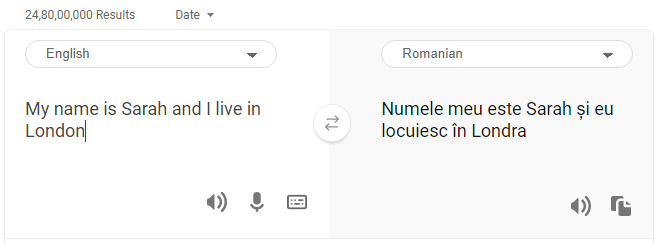

